In [ ]:
!pip install deeplake[enterprise]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import deeplake
import matplotlib.pyplot as plt
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

balanced_view = train_ds.query("select * sample by max_weight(contains(findings, 'Hernia'): 20, contains(findings, 'Pneumonia'): 8, contains(findings, 'Fibrosis'): 5, contains(findings, 'Edema'): 5, contains(findings, 'Emphysema'): 2, True: 1)")
#balanced_view = balanced_view.query("select * where findings != 0")
#test_ds = test_ds.query("select * where findings != 0")

train_ds, val_ds = balanced_view.random_split([0.85, 0.15])

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



\

hub://activeloop/nih-chest-xray-train loaded successfully.



Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



\

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
print(f'Size of train dataset: {len(train_ds)}')
print(f'Size of validation dataset: {len(val_ds)}')
print(f'Size of test dataset: {len(test_ds)}')

Size of train dataset: 73546
Size of validation dataset: 12978
Size of test dataset: 25596


In [ ]:
classes_labels = train_ds.findings.info.class_names
print(f'Number of classes: {len(classes_labels)}')
for i, label in enumerate(classes_labels):
  print(f'{i}. {label}')

Number of classes: 15
0. No Finding
1. Hernia
2. Emphysema
3. Nodule
4. Pneumonia
5. Consolidation
6. Cardiomegaly
7. Effusion
8. Mass
9. Pleural_Thickening
10. Atelectasis
11. Pneumothorax
12. Fibrosis
13. Infiltration
14. Edema


In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
    multi_hot_encoded = [0] * len(classes_labels)
    for index in findings_list:
        multi_hot_encoded[index] = 1

    return torch.Tensor(multi_hot_encoded)

batch_size = 64
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
    # Training Phase
    model.train()

    running_train_loss = 0
    #train_loss_list = []

    for i, data in enumerate(data_loader):
        inputs = data['images']
        labels = data['findings']

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        running_train_loss += loss.item() * inputs.shape[0]

        loss.backward()
        optimizer.step()

    average_loss = running_train_loss / len(data_loader)
    print(f'Training phase completed. Average loss: {average_loss:.4f}')

    # Validation Phase
    model.eval()

    running_val_loss = 0
    val_correct = 0

    with torch.no_grad():
        for i, data in enumerate(val_data_loader):
            inputs = data['images']
            labels = data['findings']

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.shape[0]

    val_average_loss = running_val_loss / len(val_data_loader)
    print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

In [ ]:
def test_model(model, data_loader, threshold):
  model.eval()

  total = 0
  correct = 0
  last_10_correct = 0
  last_10_total = 0

  # Disable gradient calculation for faster evaluation
  with torch.no_grad():
    for i, data in enumerate(data_loader):
      inputs = data['images']
      labels = data['findings']

      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      # Compute binary predictions by thresholding the output probabilities
      predicted = (outputs > threshold).float()
      # Calculate the number of correct predictions in the current batch
      batch_correct = (predicted == labels).all(dim=1).float().sum().item()
      # Calculate the total number of samples in the current batch
      batch_total = labels.size(0)

      correct += batch_correct
      total += batch_total

      last_10_correct += batch_correct
      last_10_total += batch_total

      if (i + 1) % 50 == 0 and i > 0:
        last_10_accuracy = 100 * last_10_correct / last_10_total
        average_accuracy = 100 * correct / total

        print(f'[{i + 1}]: Last 50 batches accuracy: {last_10_accuracy:.2f}%, Average accuracy so far: {average_accuracy:.2f}%')

        last_10_correct = 0
        last_10_total = 0

  accuracy = 100 * correct / total
  print('Finished Testing')
  print(f'Testing accuracy: {accuracy:.2f}%')

In [ ]:
def save_model(model, optimizer, epoch, save_path, model_name):
  # Create the save directory if it doesn't exist
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  # Create the full path for the saved model
  model_file = os.path.join(save_path, f"{model_name}_epoch_{epoch}.pth")

  # Save the model and optimizer state_dicts
  torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
  }, model_file)

  print(f"Model saved: {model_file}")

In [ ]:
def load_model(model, optimizer, load_path, device):
  # Load the saved model and optimizer state_dicts
  checkpoint = torch.load(load_path)

  # Load the model and optimizer state_dicts into the model and optimizer objects
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  # Move the model to the appropriate device (GPU or CPU)
  model.to(device)

  # Set the starting epoch for the model
  start_epoch = checkpoint['epoch']

  print(f"Model loaded: {load_path}, starting from epoch {start_epoch}")

# Usage example:
#load_path = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/MultiLabelCNN_epoch_1.pth"
#load_model(model, optimizer, load_path, device)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, device='cpu'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device

    def forward(self, inputs, targets):
        # Ensure the targets are binary (0 or 1)
        targets = targets.float().to(self.device)

        # Compute the binary cross-entropy loss
        bce_loss = F.binary_cross_entropy_with_logits(inputs.to(self.device), targets, reduction='none')

        # Compute the probability of the true class
        p_t = torch.exp(-bce_loss)

        # Compute the focal loss
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss

        # Average the focal loss over the batch
        return focal_loss.mean()

In [ ]:
# Load the pre-trained model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Adapt the first layer
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Number of filters in the bottleneck layer
num_ftrs = model.fc.in_features

# Number of labels in your dataset
num_labels = 15  # Replace 15 with your actual number of labels

# Replace the last fully connected layer with a new one
model.fc = nn.Sequential(nn.Linear(num_ftrs, num_labels))

# Unfreeze layer 4 and output layer
for name, param in model.named_parameters():
  if ('layer3' in name) or ('layer4' in name) or ('fc' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False

# Ensure the new conv1 layer is unfrozen
for param in model.conv1.parameters():
    param.requires_grad = True

# Checking if GPU is available and setting the device accordingly
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Define the loss function and optimizer
criterion = FocalLoss(alpha=1.0, device=device)
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001)

# Print the new architecture
print(model)

Running on cuda
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1,

In [ ]:
# Iterate through the layers and print if they are frozen
for name, param in model.named_parameters():
    print(f"Layer: {name}, Frozen: {not param.requires_grad}")

Layer: conv1.weight, Frozen: False
Layer: bn1.weight, Frozen: True
Layer: bn1.bias, Frozen: True
Layer: layer1.0.conv1.weight, Frozen: True
Layer: layer1.0.bn1.weight, Frozen: True
Layer: layer1.0.bn1.bias, Frozen: True
Layer: layer1.0.conv2.weight, Frozen: True
Layer: layer1.0.bn2.weight, Frozen: True
Layer: layer1.0.bn2.bias, Frozen: True
Layer: layer1.0.conv3.weight, Frozen: True
Layer: layer1.0.bn3.weight, Frozen: True
Layer: layer1.0.bn3.bias, Frozen: True
Layer: layer1.0.downsample.0.weight, Frozen: True
Layer: layer1.0.downsample.1.weight, Frozen: True
Layer: layer1.0.downsample.1.bias, Frozen: True
Layer: layer1.1.conv1.weight, Frozen: True
Layer: layer1.1.bn1.weight, Frozen: True
Layer: layer1.1.bn1.bias, Frozen: True
Layer: layer1.1.conv2.weight, Frozen: True
Layer: layer1.1.bn2.weight, Frozen: True
Layer: layer1.1.bn2.bias, Frozen: True
Layer: layer1.1.conv3.weight, Frozen: True
Layer: layer1.1.bn3.weight, Frozen: True
Layer: layer1.1.bn3.bias, Frozen: True
Layer: layer1.2.c

In [ ]:
model = model.to(device)

In [ ]:
# Training and testing the model

num_epochs = 10
save_path = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/test_v6"
model_name = "Resnet50"

for epoch in range(num_epochs):
    print(f"------------------ Training Epoch {epoch + 1} ------------------")
    train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)


    save_model(model, optimizer, epoch + 1, save_path, model_name)

------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:23<00:00, 91.2MB/s]


Shuffle buffer filling is complete.
Training phase completed. Average loss: 2.1901
Validation phase completed. Average loss: 5.9648
Model saved: /content/drive/MyDrive/SSN_Projekt/Saved_Models/test_v6/Resnet50_epoch_1.pth
------------------ Training Epoch 2 ------------------
Training phase completed. Average loss: 1.6676
Validation phase completed. Average loss: 7.7240
Model saved: /content/drive/MyDrive/SSN_Projekt/Saved_Models/test_v6/Resnet50_epoch_2.pth
------------------ Training Epoch 3 ------------------
Training phase completed. Average loss: 1.1529
Validation phase completed. Average loss: 8.1787
Model saved: /content/drive/MyDrive/SSN_Projekt/Saved_Models/test_v6/Resnet50_epoch_3.pth
------------------ Training Epoch 4 ------------------


Process ForkPoolWorker-18:
Process ForkPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/local/lib/python3.10/dist-packages/indra/pytorch/loader.py", line 354, in early_transform_collate
    out = transform_collate_batch(
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    res

KeyboardInterrupt: ignored

In [ ]:
# Function to calculate multi-label accuracy
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    return ((inp>thresh)==targ.bool()).float().mean()

In [ ]:
load_path = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/test_v6/Resnet50_epoch_3.pth"
load_model(model, optimizer, load_path, device)

Model loaded: /content/drive/MyDrive/SSN_Projekt/Saved_Models/test_v6/Resnet50_epoch_3.pth, starting from epoch 3


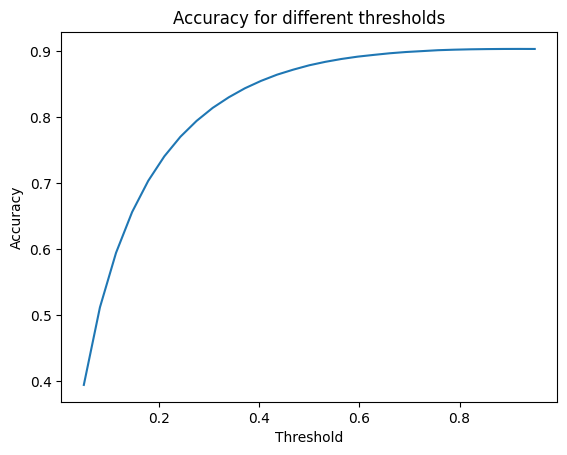

In [ ]:
# Set your model to evaluation mode
model.eval()

# Containers to store predictions and true labels
all_preds = torch.tensor([]).to(device)
all_targs = torch.tensor([]).to(device)

# Go through the train_loader
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_preds = torch.cat((all_preds, output), dim=0)
        all_targs = torch.cat((all_targs, target), dim=0)

# Calculate accuracies for different thresholds
thresholds = torch.linspace(0.05, 0.95, 29).cpu().numpy()  # Convert to numpy array
accuracies = [accuracy_multi(all_preds.sigmoid(), all_targs, thresh=i).cpu().numpy() for i in thresholds]  # Convert to numpy array

# Plot the accuracies
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy for different thresholds")
plt.show()

In [ ]:
thresh = 0.7

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        all_preds.append(outputs)
        all_labels.append(labels)

all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

val_accuracy = accuracy_multi(all_preds.sigmoid(), all_labels, thresh).item()
print(f"Val accuracy: {val_accuracy}")

Val accuracy: 0.8992863297462463


ROC AUC for label 0: 0.6355373437202279
ROC AUC for label 1: 0.6588310101829651
ROC AUC for label 2: 0.6476524206999095
ROC AUC for label 3: 0.5978348279933635
ROC AUC for label 4: 0.5741557899099531
ROC AUC for label 5: 0.6272629386864969
ROC AUC for label 6: 0.7014839948628805
ROC AUC for label 7: 0.7131995355975632
ROC AUC for label 8: 0.6116354666511092
ROC AUC for label 9: 0.6049037632819922
ROC AUC for label 10: 0.6328992323495097
ROC AUC for label 11: 0.6683387874693498
ROC AUC for label 12: 0.6574687974958509
ROC AUC for label 13: 0.588332810966657
ROC AUC for label 14: 0.7150986331473544


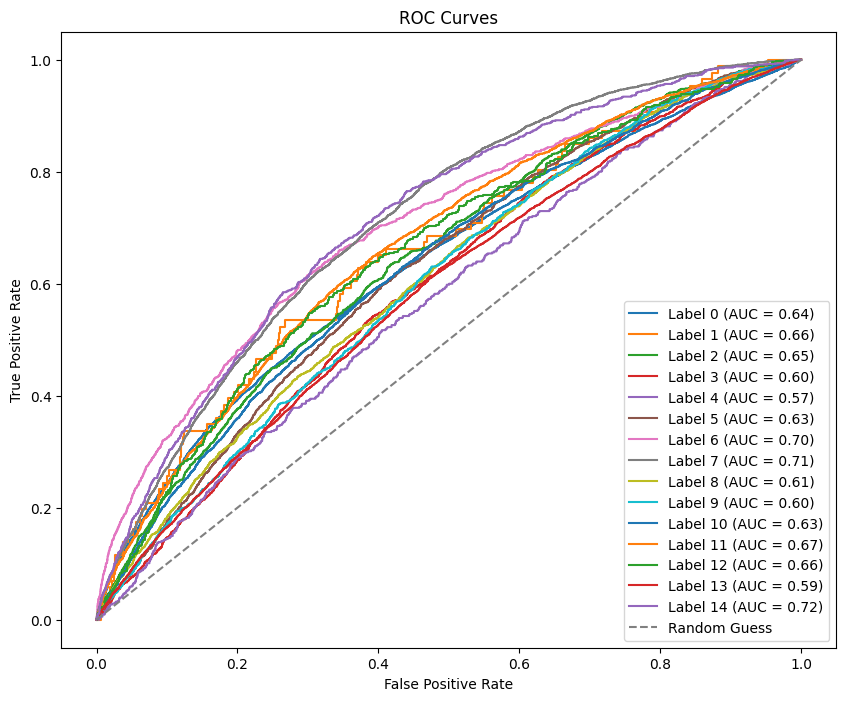

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming that you have the test_loader and the resnet50 model defined
model.eval()
#all_preds = []
#all_labels = []

#with torch.no_grad():
#    for inputs, labels in test_loader:
#        inputs, labels = inputs.to(device), labels.to(device)
#        outputs = model(inputs)
#        all_preds.append(outputs.sigmoid())  # Convert to probabilities
#        all_labels.append(labels)

#all_preds = torch.cat(all_preds, dim=0)
#all_labels = torch.cat(all_labels, dim=0)

# Concatenate the results
all_preds = all_preds.cpu().numpy()
all_labels = all_labels.cpu().numpy()

# Calculate and print the ROC AUC for each label, and plot the ROC curve
num_labels = all_labels.shape[1]
plt.figure(figsize=(10, 8))

for label_index in range(num_labels):
    try:
        auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
        print(f'ROC AUC for label {label_index}: {auc_score}')

        fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
        plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
        # This error can occur if there is no positive class present in the labels,
        # which means that the ROC AUC score is not defined for this batch.
        print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [ ]:
$0p